In [1]:
import pnadc
from tqdm import tqdm
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import ppscore
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
paths_2020 = [*Path('pnadpy/').glob('*2020.csv')]

In [3]:
if not paths_2020:
    pnadc.get_all([2020], path = 'pnadpy/', protocol = 'https')
    paths_2020 = [*Path('pnadpy/').glob('*2020.csv')]

In [4]:
def convert_int(df, dtype = int, nan_fill = -1, valid_range = (0,100)):
    '''
    checks the columns that are composed of only integers, if so, cast to integer
    '''
    if df.__class__ == dd.DataFrame:
        return df.map_partitions(convert_int)
    
    for col in df.columns:
        if (df[col].dropna() == df[col].dropna().values.astype(int)).all():
            if not valid_range is None:
                if all(df[col].between(*valid_range)):
                    df[col] = df[col].fillna(nan_fill).astype(dtype)
            else:
                df[col] = df[col].fillna(nan_fill).astype(dtype)
                                                       
    return df

def rename_variables_pnadc(df, pnadc_dictionary_path):    
    return

def create_parquet_pnadc(path, saving_path = 'PNADC/pnadc_compiled.parquet'):
    with ProgressBar():
        data = dd.read_csv(path)
        data = data.repartition('100MB').drop_duplicates()
        data.to_parquet(saving_path)
    return saving_path

In [5]:
#create_parquet_pnadc(path = 'PNADC/*.csv')
data = dd.read_csv(paths_2020)

In [6]:
len(data)

1560869

In [7]:
#data = data.astype(str)
data = convert_int(data, dtype = 'str')


In [65]:
rendimentos_cols = [
    'V405012',
    'V405022',
    'V405112',
    'V405122',
    'V405812',
    'V405822',
    'V405912',
    'V405922',    
    'V403322',
    'V403412',
    'V403422',
    'V405812',
    'V403312',
    
]
rendimentos = data[rendimentos_cols].fillna(0).sum(axis = 1).compute()

0.6200898345729206


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


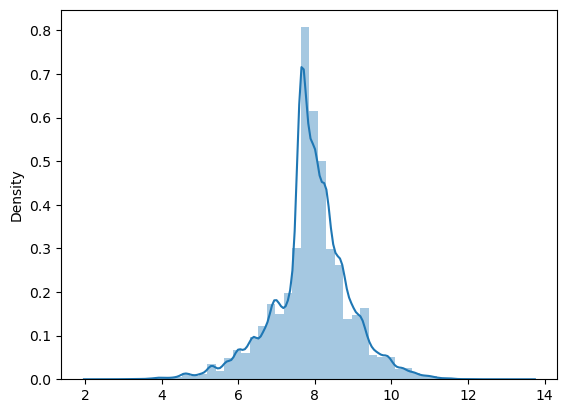

In [68]:
print((rendimentos==0).mean())
plt.clf()
sns.distplot(np.log(rendimentos[rendimentos > 0].sample(frac = 0.1)))
plt.show()

In [10]:
raca = data['V2010']

raca.compute().value_counts(1)

4    0.515522
1    0.393977
2    0.081678
3    0.004456
5    0.004235
9    0.000130
Name: V2010, dtype: float64

In [11]:
data.partitions[0].compute()

,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,VD4020,VD4023,VD4030,VD4031,VD4032,VD4033,VD4034,VD4035,VD4036,VD4037
0,2020.0,1,11,11.0,NaN,110000016.0,1110011.0,1,7,5,...,1500.0,NaN,NaN,40.0,NaN,NaN,NaN,40.0,3.0,3.0
1,2020.0,1,11,11.0,NaN,110000016.0,1110011.0,1,7,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020.0,1,11,11.0,NaN,110000016.0,1110011.0,1,7,5,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020.0,1,11,11.0,NaN,110000016.0,1110011.0,1,7,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020.0,1,11,11.0,NaN,110000016.0,1110011.0,3,7,5,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142433,2020.0,1,24,24.0,24.0,240029989.0,2410011.0,2,8,1,...,2000.0,NaN,NaN,60.0,NaN,NaN,NaN,60.0,5.0,5.0
142434,2020.0,1,24,24.0,24.0,240029989.0,2410011.0,2,8,1,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142435,2020.0,1,24,24.0,24.0,240029989.0,2410011.0,3,8,1,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142436,2020.0,1,24,24.0,24.0,240029989.0,2410011.0,3,8,1,...,1800.0,NaN,NaN,44.0,NaN,NaN,NaN,44.0,3.0,3.0


# Find Confounders

Confounders are good predictors of both the treatment and the observed outcome.
Knowing what are these variables are usefull because in order to remove bias we have to control for confounders

In [12]:
#filter1 = data['']
data['V403311'].compute().value_counts(1, dropna = False)

NaN    0.621201
3.0    0.137785
2.0    0.092053
1.0    0.050446
4.0    0.044627
5.0    0.030315
6.0    0.016450
7.0    0.005626
8.0    0.001496
Name: V403311, dtype: float64

In [13]:
data['V2010'].compute().value_counts(1, dropna = False)

4    0.515522
1    0.393977
2    0.081678
3    0.004456
5    0.004235
9    0.000130
Name: V2010, dtype: float64

## Filters

In [69]:
#msk = ~data['V403311'].isna()
msk = data['V2009'].between(18,65) #idade entre 18 e 65 anos

## Predictive Power Scores

In [70]:
data['V2010'] = data['V2010'].astype(str)

In [71]:
rendimento_pps_scores = ppscore.predictors(
    data[msk].compute(),
    y = 'V403311'
)

In [72]:
cor_pps_scores = ppscore.predictors(
    data[msk].compute(),
    y = 'V2010'
)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than

In [73]:
rendimento_pps_scores = rendimento_pps_scores.query('ppscore > 0')
rendimento_pps_scores

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V403312,V403311,0.995247,regression,True,mean absolute error,1.014000,0.004820,DecisionTreeRegressor()
1,VD4016,V403311,0.995050,regression,True,mean absolute error,1.014000,0.005019,DecisionTreeRegressor()
2,VD4019,V403311,0.950816,regression,True,mean absolute error,1.014000,0.049873,DecisionTreeRegressor()
3,V403412,V403311,0.737121,regression,True,mean absolute error,1.014000,0.266559,DecisionTreeRegressor()
4,VD4017,V403311,0.736944,regression,True,mean absolute error,1.014000,0.266738,DecisionTreeRegressor()
5,VD4020,V403311,0.721712,regression,True,mean absolute error,1.014000,0.282184,DecisionTreeRegressor()
6,V403411,V403311,0.707712,regression,True,mean absolute error,1.014000,0.296380,DecisionTreeRegressor()
7,V405122,V403311,0.422942,regression,True,mean absolute error,0.642857,0.370966,DecisionTreeRegressor()
8,V405022,V403311,0.357941,regression,True,mean absolute error,0.642857,0.412753,DecisionTreeRegressor()
9,V405812,V403311,0.321484,regression,True,mean absolute error,1.484791,1.007454,DecisionTreeRegressor()


In [74]:
cor_pps_scores = cor_pps_scores.query('ppscore > 0')
cor_pps_scores

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V405022,V2010,5.817496e-01,classification,True,weighted F1,0.423161,0.758737,DecisionTreeClassifier()
1,V405122,V2010,4.374822e-01,classification,True,weighted F1,0.423161,0.675518,DecisionTreeClassifier()
2,V401512,V2010,3.843443e-01,classification,True,weighted F1,0.470885,0.674247,DecisionTreeClassifier()
3,V405121,V2010,3.333081e-01,classification,True,weighted F1,0.423161,0.615426,DecisionTreeClassifier()
4,posest,V2010,3.174277e-01,classification,True,weighted F1,0.423800,0.606702,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
80,V40332,V2010,6.594471e-06,classification,True,weighted F1,0.600270,0.600273,DecisionTreeClassifier()
81,V40342,V2010,3.159129e-06,classification,True,weighted F1,0.599913,0.599914,DecisionTreeClassifier()
82,V40162,V2010,8.046306e-07,classification,True,weighted F1,0.580659,0.580660,DecisionTreeClassifier()
83,VD4005,V2010,1.500655e-07,classification,True,weighted F1,0.549960,0.549960,DecisionTreeClassifier()


In [75]:
cor_pps_scores.merge(rendimento_pps_scores, how = 'inner', on = 'x', suffixes = ('_cor', '_rendimento'))[['x','ppscore_cor', 'ppscore_rendimento']]

,x,ppscore_cor,ppscore_rendimento
0,V405022,0.581750,0.357941
1,V405122,0.437482,0.422942
2,V401512,0.384344,0.053399
3,V405121,0.333308,0.247500
4,V405812,0.215918,0.321484
5,V405021,0.206786,0.070320
6,V4019,0.196138,0.077318
7,V405811,0.193577,0.286737
8,V403312,0.185943,0.995247
9,VD4019,0.181110,0.950816


In [78]:
pnadc.query('V405122', 'pnadpy/input_PNADC_trimestral.txt', )

{'column': 'V405122', 'desc': 'Valor do rend. efe. em produtos'}

In [61]:
#data = data.sample(0.1)[['V3009A', 'V2010']]